# Imports

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
%matplotlib inline
import matplotlib.pyplot as pl

In [3]:
import numpy.linalg as la

In [4]:
import numpy.random as rnd

In [5]:
import pandas as pd
from pandas import Series, DataFrame

In [6]:
from time import sleep
import ipywidgets as ipw

In [7]:
from types import SimpleNamespace

In [8]:
## changing the width of cells
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

# Prepare examples

## Calculation of $f, df, d^2f$
We use tensorflow only here to calculate derivatives in this section. The rest of the notebook will be tensorflow-free.

In [9]:
def get_f_df_ddf(fun):
    floatX = np.float64

    sess = tf.InteractiveSession()

    x_tf = tf.Variable([0, 0], dtype = floatX)

    sess.run(x_tf.initializer)

    f_tf = fun(x_tf)

    df_tf = tf.gradients(f_tf, x_tf)[0]

    ddf_tf =  tf.hessians(f_tf, x_tf)[0]

    def f(x):
        return sess.run(f_tf, {x_tf: x} )

    def df(x):
        return sess.run(df_tf, {x_tf: x} )

    def ddf(x):
        return sess.run(ddf_tf, {x_tf: x} )
    
    return f, df, ddf

## Plot $f$

In [10]:
def plot_fun(f, bounds = [[-1, -1], [1, 1]], ax = None):
    [[x0_min, x1_min], [x0_max, x1_max]] = bounds
    X, Y = np.mgrid[x0_min:x0_max:30j, x0_min:x0_max:30j]

    Z = np.vectorize(lambda x,y: f([x, y]))(X, Y)

    if ax is None:
        fig, ax = pl.subplots()
        
    ax.set_aspect("equal")
    ax.set_xlim(x0_min, x0_max)
    ax.set_ylim(x1_min, x1_max)

    p = ax.pcolor(X, Y, Z, cmap=pl.cm.RdBu, vmin=Z.min(), vmax=Z.max())
    cb = ax.figure.colorbar(p)
    
    return ax

## Examples

### Rosenbrock

In [11]:
def Rosenbrock(x):
    x0, x1 = x[0], x[1]
    return 1000 *(x1 - x0**2) ** 2 + (1 - x0)**2

fun = Rosenbrock
plot_bounds = 1.2 * np.array([[-1, -1], [1, 1]])
x_start = np.array([-1, 0.7])

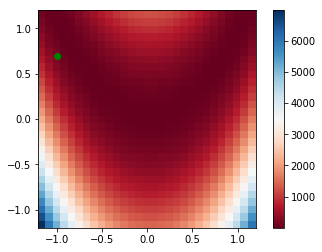

In [12]:
%matplotlib inline
fig, ax = pl.subplots()
plot_fun(fun, plot_bounds, ax)
pl.scatter(*x_start, c = "g")

### Long quadratic

In [13]:
def long_quadratic(x):
    x0, x1 = x[0], x[1]
    return 10 * x1**2 + x0**2

fun = long_quadratic
plot_bounds = [[-1, -1], [1, 1]]
x_start = [-0.9, 0.1]

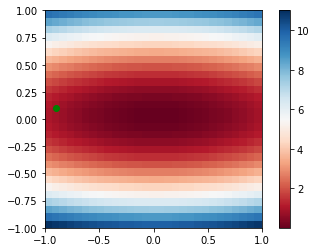

In [14]:
%matplotlib inline
plot_fun(fun, plot_bounds)
pl.scatter(*x_start, c = "g")

## Set the example

In [15]:
f, df, ddf = get_f_df_ddf(fun)
x = x_start
f(x), df(x), ddf(x)

(0.91, array([-1.8,  2. ]), array([[ 2.,  0.],
        [ 0., 20.]]))

# Auxilliary classes and methods

In [16]:
class Rememberer:
    def __init__(self, f):
        self.f = f
        self.history = DataFrame()
        
    def __call__(self, x):
        val = self.f(x)
        self.history = self.history.append(
            other = {
                "x": x,
                "f": val,
            },
            ignore_index = True
        )
        
        return val

In [17]:
r = Rememberer(lambda x : np.array(x)**2)
for i in range(4):
    print(i, r(i))
r.history

0 0
1 1
2 4
3 9


,f,x
0,0.0,0.0
1,1.0,1.0
2,4.0,2.0
3,9.0,3.0


# Wolfe
We follow Nocedal, Wright: Numerical Optimization; Chapter 3. 
### Wolfe conditions
Here are the *strong Wolfe conditions* from pg. 34:
$$f(x_k + \alpha_k p_k) \leq f(x_k) + c_1 \alpha_k \nabla f_k^T p_k \tag{3.7a}$$
$$|\nabla f(x_k + \alpha_k p_k) p_k| \leq c_2 |\nabla f_k^T p_k| \tag{3.7b}$$
where $0< c_1 < c_2< 1$
They call (3.7a) the
*sufficient decrease condition* and (3.7b) the *curvature condition*.

### Restriction to a line
In our line-search, we are given $x_k, p_k$ and we want to find $\alpha_k$. Since $k$ is fixed, we drop it and use the index on $\alpha$ in our line search algorithm. We also restrict $f$ to line:


$$\phi(\alpha) := f(x + \alpha p) $$

We assume $p$ is a descent direction so $\phi'(0) < 0$.
We want to find $\alpha$ satisfying:
$$ \phi(\alpha) \leq \phi(0) + c_1 \phi'(\alpha) \tag{sufficient decrease}$$
$$ \big|\phi'(\alpha)\big| \leq c_2 \big|\phi'(0)\big| \tag{curvature condition}$$

### Bracketing phase
![Image1](Wolfe_line_search_bracketing.png)

### Zooming phase
![Image1](Wolfe_line_search_zooming.png)

In the whole process:

a) the interval bounded by `a_lo`, `a_hi` contains step-lengths that satisfy Wolfe.
  (Warning: `a_hi` can be smaller than `a_lo`.)

b) `a_lo` satisfies the 'sufficient decrease' and
  $\phi(a_{lo}) = \min \{\phi(a)\big| \text{for } a \text{ that we calculated so far and } a \text{ satisfied sufficient decrease}\}$.

c) in particular `a_hi` either does not satisfy 'sufficient decrease' or 
   it does and in that case $\phi(a_{hi}) > \phi(a_{lo})$.

d) $\phi$ is decreasing at $a_{lo}$ in the direction towards $a_{hi}$. Formally$$\phi'(a_{lo})\cdot(a_{hi} - a_{lo}) < 0$$ 


In [18]:
def wolfe_linear_search(
    phi, d_phi,
    alpha_init,
    c1 = 0.5,
    c2 = 0.7,
    phi_0 = None, d_phi_0 = None,
    alpha_max = None,
    
    bracketing_augment_method = lambda alpha, **kwargs: 2 * alpha,
    

    max_noof_bracketing_steps = 10,
    max_noof_zooming_steps = 10,
    
    printing = True, ax = None,
    plotting_params = dict()
):

    if phi_0 is None:
        phi_0 = phi(0)
        
    if d_phi_0 is None:
        d_phi_0 = d_phi(0)
    

    ## initialize plotting
    plotting = ax is not None
    if plotting:
        phi = Rememberer(phi)
        pl_a_max = 5 * alpha_init
            
        if plotting_params.get("plot_fun", False):
            ## we evaluate `phi` on a grid 
            ## so the calculated values will be written into `phi.history`.
            for x in np.linspace(0, pl_a_max, plotting_params.get("n", 10)):
                phi(x)
        else:
            phi.history = phi.history.append({"x": 0, "f": phi_0}, ignore_index = True)
    
        fun_plot = pl.plot(phi.history.x, phi.history.f)[0]
        
            
        # plot c1, c2 lines
        ax.autoscale(False)
        pl.plot([0, pl_a_max],[phi_0, phi_0 + c1 * d_phi_0 * pl_a_max],)
        pl.plot([0, pl_a_max],[phi_0, phi_0 + c2 * d_phi_0 * pl_a_max],)
        ax.autoscale(True)

        ## prepare the dots depicting current state of our algorithm
        dots = ax.scatter(0, phi_0)

    def update_plot(new_dots = []):
        if plotting:
            dots.set_offsets(new_dots)
            
            vvv = phi.history.sort_values("x")
            fun_plot.set_xdata(vvv.x)
            fun_plot.set_ydata(vvv.f)
            
            # recompute the ax.dataLim
            ax.relim()
            # update ax.viewLim using the new dataLim
            ax.autoscale_view()
            
            # redraw
            ax.figure.canvas.draw()
            
            if "sleep_time" in plotting_params:
                sleep(plotting_params["sleep_time"])
            

    ## Initialize bracketing phase
    a_prev = 0
    phi_a_prev = phi_0

    a = alpha_init
    phi_a = phi(a)

    
    if plotting:
        # update plot
        update_plot([[a, phi_a], [a_prev, phi_a_prev]])
        

    ###################
    ## Bracketing phase

    for i in range(max_noof_bracketing_steps):
        print("New bracketing step with a_prev={}; a={}".format(a_prev, a))
        # If the 'sufficient descent' fails or we are already increasing (from `a_prev`)
        # then this means that we have increased `a` far enough and we can start zooming.
        if (phi_a > phi_0 + c1 * a * d_phi_0) or (phi_a >= phi_a_prev):
            a_lo, a_hi = a_prev, a
            phi_a_lo, phi_a_hi = phi_a_prev, phi_a

            if printing:
                if (phi_a > phi_0 + c1 * a * d_phi_0):
                    print("Sufficient descent fails.")
                if (phi_a >= phi_a_prev):
                    print("phi_a >= phi_a_prev")
                print("You can start zooming with a_lo={}, a_hi={}".format(a_lo, a_hi))
            break

        d_phi_a = d_phi(a)

        # If 'curvature condition' is satisfied then we are done since we already know 
        # that a satisfies the 'sufficient descent'.
        if np.abs(d_phi_a) <= c2 * np.abs(d_phi_0):
            if printing:
                print("You are done and you can use alpha ={}".format(a))
            if plotting:
                ## plot the final alpha
                ax.scatter(a, phi_a, s = 40, c = "r")
                ax.figure.canvas.draw()

            return a

        # If `phi` is increasing in `a`, we can start zooming.
        if(d_phi_a >= 0):
            a_lo, a_hi = a, a_prev
            phi_a_lo, phi_a_hi = phi_a, phi_a_prev
            if printing:
                print("d_phi_a >= 0;")
                print("You can start zooming with a_lo={}, a_hi={}".format(a_lo, a_hi))
            break

        ## If none of the previous happens, we must start everything with larger `a`:
        # choose new a in (a, alpha_max):
        if a == alpha_max:
            raise Exception("We reached a == alpha_max in bracketing phase. Can't augment it any more.")
            
        a_new = bracketing_augment_method(alpha = a)
        
        if alpha_max is not None:
            a_new = min(a_new, alpha_max)

        a_prev, phi_a_prev = a, phi_a
        a, phi_a = a_new, phi(a_new)

        if printing:
            print("Our a={} seems not to be large enough. Try with larger a ={}".format(a_prev, a))
        if plotting:
            update_plot([[a, phi_a], [a_prev, phi_a_prev]])
            
    else:
        raise Exception("Too many steps in bracketing phase.")
        
    

    ################
    ## Zooming phase
    # In the whole process:
    # a) the interval bounded by `a_lo`, `a_hi` contains step-lengths that satisfy Wolfe.
    #   (Warning: `a_hi` can be smaller than `a_lo`.)
    # b) `a_lo` satisfies the 'sufficient decrease' and
    #   `phi(a_lo) = min {phi(a) that we calculated so far and a satisfied sufficient decrease}`.
    # c) in particular `a_hi` either does not satisfy 'sufficient decrease' or 
    #    it does and in that case it phi(a_hi) > phi(a_lo)
    # d) $\phi'(a_{lo})\cdot(a_{hi} - a_{lo})$ 
    # This means that phi is decreasing in `a_lo` in the direction towards `a_hi`.


    
    for j in range(max_noof_zooming_steps):

        print("New zooming step with a_lo = {}; a_hi = {}".format(a_lo, a_hi))
        # update plot
        if plotting:
            update_plot([[a_lo, phi_a_lo], [a_hi, phi_a_hi]])
            

        # choose `a` between `a_lo` and `a_hi`
        a = (a_lo + a_hi) / 2
        phi_a = phi(a)

        # If 'sufficient decrease' at `a` fails, or we get larger value than at `a_lo`
        # then we shrink the interval: keep `a_lo` and take `a_hi = a`.
        if (phi_a > phi_0 + c1 * a * d_phi_0) or (phi_a >= phi_a_lo):
            a_hi = a
            phi_a_hi = phi_a
        else:
            # Now we know that 'sufficient decrease' holds at `a`.
            # Check the 'curvature condition':
            d_phi_a = d_phi(a)    
            if abs(d_phi_a) <= c2 * abs(d_phi_0):
                print("You are done and you can use alpha ={}".format(a))
                break

            # If we got here, we know that 'curvature condition' failed so we must 
            # update our interval. 
            # We also know that `a` satisfies the 'sufficient decrease' and `phi_a < phi_lo'.
            # Thus (according to (b)) in the next step, `a` must become the new `a_lo`.
            # Therefore new `a_lo, a_hi`  will be either `a, a_hi` or `a, a_lo`.
            # We choose so that
            # phi will be decreasing at `a_lo` in the direction towards `a_hi`.
            if d_phi_a * (a_hi - a_lo) >= 0:
                a_hi = a_lo
                phi_a_hi = phi_a_lo

            a_lo = a
            phi_a_lo = phi_a
    else:
        raise Exception("Too many steps in zooming phase.")
        
        
    if plotting:
        ## plot the final alpha
        ax.scatter(a, phi_a, s = 40, c = "r")
        ax.figure.canvas.draw()

    return a


## 1D example (Requires `interpolators` to be installed)

In [19]:
from interpolators import Interpolator

ModuleNotFoundError: No module named 'interpolators'

In [20]:
control_x = [-1, 0, 1, 2, 3, 4]
control_vals = [1.2, 1] + list(rnd.rand(len(control_x) - 2))

In [21]:
phi = Interpolator([control_x], control_vals)
d_phi = lambda x: phi.ev(x, derivative =0)

NameError: name 'Interpolator' is not defined

<IPython.core.display.Javascript object>


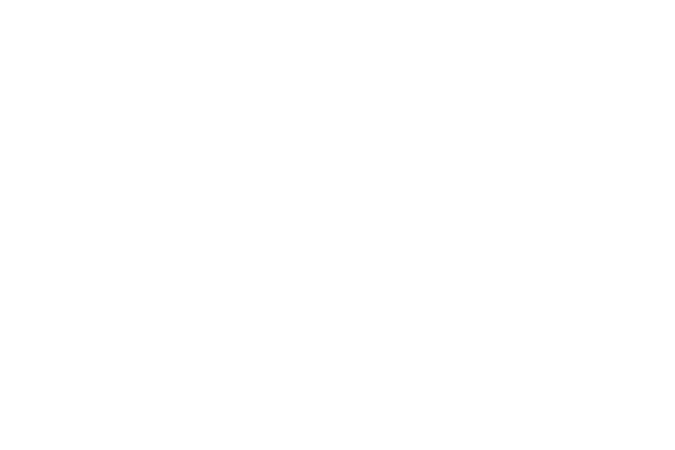

NameError: name 'phi' is not defined

<IPython.core.display.Javascript object>


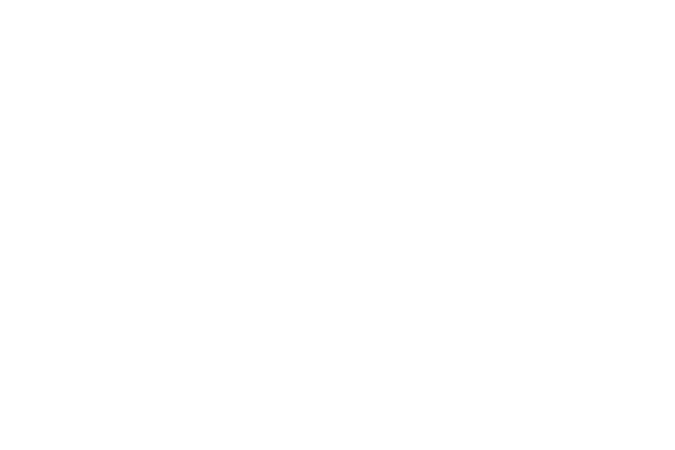

In [22]:
%matplotlib notebook
fig, ax = pl.subplots()

wolfe_linear_search(
    phi = phi, d_phi = d_phi,
    alpha_init = 1,
    alpha_max = control_x[-1],
    ax = ax,
    plotting_params = {
        "plot_fun": True,
        #"sleep_time": 1,
    }
)

## 2D example

In [23]:
class Wolfe_Linear_Search:
    def __init__(self,
        f, df, 
        c1 = 0.01,
        c2 = 0.4,
        
        bracketing_augment_method = lambda alpha, **kwargs: 2 * alpha,

        max_noof_bracketing_steps = 10,
        max_noof_zooming_steps = 10,

        printing = True, 
        ax = None,
        plotting_params = dict()
    ):
        """
        0 < c1 < c2 < 1

        `plotting_params` is a dictionary. It can comtain:
            `plot_fun` : Boolean whether the function should be plotted at the start.
            `n`: if it is plotted, how many points are calculated
            'sleep_time`: how many seconds we should wait after each step. Defaults 0.
        """
        self.f = f
        self.df = df
        
        self.c1 = c1
        self.c2 = c2
        
        self.bracketing_augment_method = bracketing_augment_method
        
        self.max_noof_bracketing_steps = max_noof_bracketing_steps
        self.max_noof_zooming_steps = max_noof_zooming_steps
        
        self.printing = printing
        self.ax = ax
        self.plotting_params = plotting_params
    
    def search(self,
        x, p, 
        f_x = None, df_x = None, 
        alpha_init = 1,
        alpha_max = None,
    ):
        """
        Returns an object with fields: `alpha, x_new,f_x_new, df_x_new`
        """
        ## We want to memorize the evaluations, so that we can return the values at the new `x`
        f_remember = Rememberer(self.f)
        df_remember = Rememberer(self.df)
        
        ## restrict `f` and `df` to line {x + a * p| a > 0}
        def phi(a):
            return f_remember(x + a * p)

        d_phi = lambda a: p @ df_remember(x + a * p)
        

        ## do the search
        if self.ax is not None:
            self.ax.clear()
            
        alpha = wolfe_linear_search(
            phi = phi, 
            d_phi = d_phi,
            alpha_init = alpha_init,
            c1 = self.c1,
            c2 = self.c2,
            
            phi_0 = f_x, 
            d_phi_0 = p @ f_x if f_x is not None else None,
            
            alpha_max = alpha_max,

            bracketing_augment_method = self.bracketing_augment_method,

            max_noof_bracketing_steps = self.max_noof_bracketing_steps,
            max_noof_zooming_steps = self.max_noof_zooming_steps,

            printing = self.printing, 
            ax = self.ax,
            plotting_params = self.plotting_params
        )

        ## update `x`
        x_new = x + alpha * p

        ## retrieve value f_x from history or calculate it
        if all(f_remember.history.x.iloc[-1] == x_new):
            f_x_new = f_remember.history.f.iloc[-1]
        else:
            raise Exception("I think the value of `f` at `x` should have been calkulated in Wolfe search.")

        ## retrieve value df_x from history or calculate it
        if all(df_remember.history.x.iloc[-1] == x_new):
            df_x_new = df_remember.history.f.iloc[-1]
        else:
            raise Exception("I think the value of `df` at `x` should have been calkulated in Wolfe search.")
            
        ## 
        return SimpleNamespace(
            alpha = alpha,
            x_new = x_new,
            f_x_new = f_x_new,
            df_x_new = df_x_new
        )



# Newton with Wolfe search

<IPython.core.display.Javascript object>


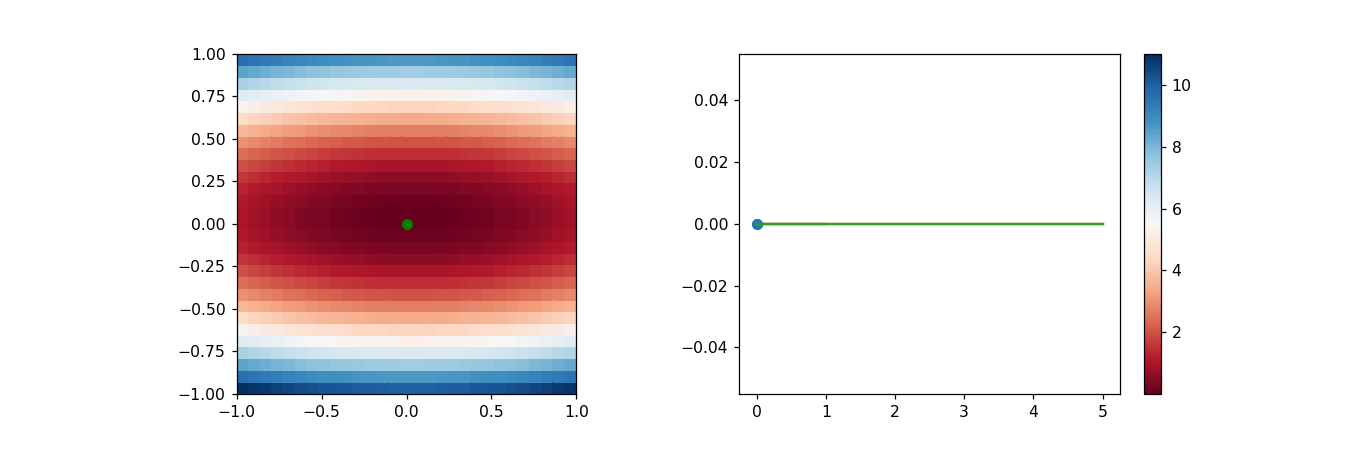

In [31]:
%matplotlib notebook
fig, axs = pl.subplots(1, 2, figsize = (12, 4))
ax = plot_fun(f, bounds =  plot_bounds, ax = axs[0])
current_dot = ax.scatter(*x_start, c = "green")

In [32]:
## initialization
x = x_start
f_x = f(x)
df_x = df(x)

wolfe_lin_srch = Wolfe_Linear_Search(
    f = f, df = df,
    
    c1=0.01, c2=0.4,
    
    max_noof_bracketing_steps=20, 
    max_noof_zooming_steps=40,
    
    ax = axs[1],
    plotting_params = {
        "plot_fun": False,
        "sleep_time": 1,
    }
)

In [34]:
# Newton Method
## find the direction `p`
B = ddf(x)
p = - la.inv(B) @ df(x)

## perform the line search ; 
## `lsr` = line search results  
lsr = wolfe_lin_srch.search(
    x = x, p = p,
    
)

## update `x, f_x, df_x`
x, f_x, df_x = lsr.x_new, lsr.f_x_new, lsr.df_x_new

## plotting and printing
current_dot.set_offsets([x])
print("x ={}; f(x) = {}".format(x, f(x)))

New bracketing step with a_prev=0; a=1
phi_a >= phi_a_prev
You can start zooming with a_lo=0, a_hi=1
New zooming step with a_lo = 0; a_hi = 1
New zooming step with a_lo = 0; a_hi = 0.5
New zooming step with a_lo = 0; a_hi = 0.25
New zooming step with a_lo = 0; a_hi = 0.125
New zooming step with a_lo = 0; a_hi = 0.0625
New zooming step with a_lo = 0; a_hi = 0.03125
New zooming step with a_lo = 0; a_hi = 0.015625
New zooming step with a_lo = 0; a_hi = 0.0078125
New zooming step with a_lo = 0; a_hi = 0.00390625
New zooming step with a_lo = 0; a_hi = 0.001953125
New zooming step with a_lo = 0; a_hi = 0.0009765625
New zooming step with a_lo = 0; a_hi = 0.00048828125
New zooming step with a_lo = 0; a_hi = 0.000244140625
New zooming step with a_lo = 0; a_hi = 0.0001220703125
New zooming step with a_lo = 0; a_hi = 6.103515625e-05
New zooming step with a_lo = 0; a_hi = 3.0517578125e-05
New zooming step with a_lo = 0; a_hi = 1.52587890625e-05
New zooming step with a_lo = 0; a_hi = 7.62939453125e

Exception: Too many steps in zooming phase.

# BFGS with Wolfe search

In [26]:
def BFGS_update_B(B0, x1, x0, df_x1, df_x0):
    y = (df_x1 - df_x0).reshape([-1, 1])
    s = (x1 - x0).reshape([-1, 1])
    
    assert y.T @ s > 0
    
    B1 = B0 + (y @ y.T) / (y.T @ s) - (B0 @ s ) @ (s.T @ B0) / (s.T @ B0 @ s)
    return B1

<IPython.core.display.Javascript object>


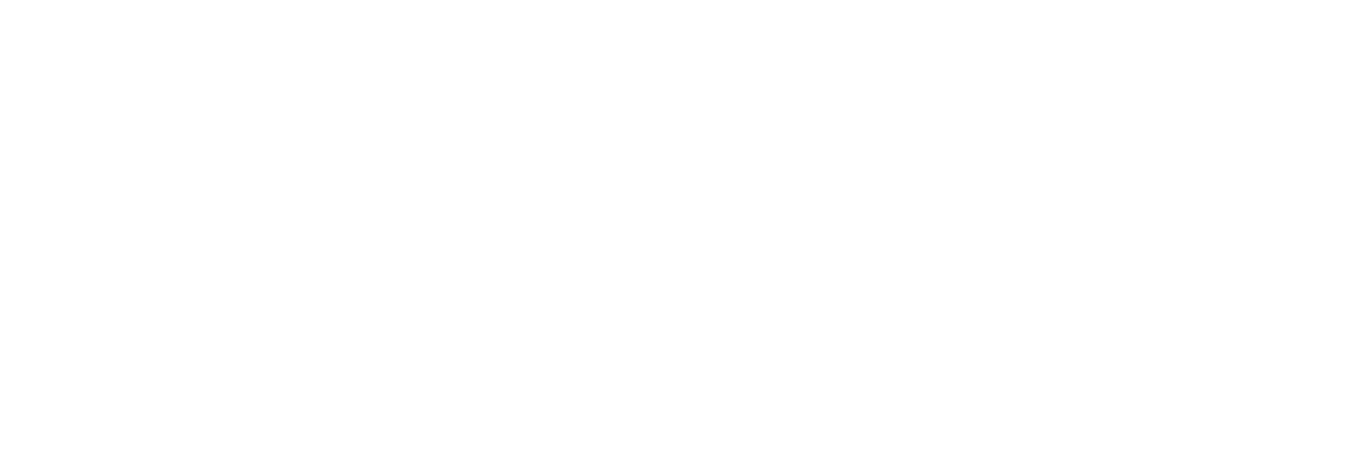

<IPython.core.display.Javascript object>


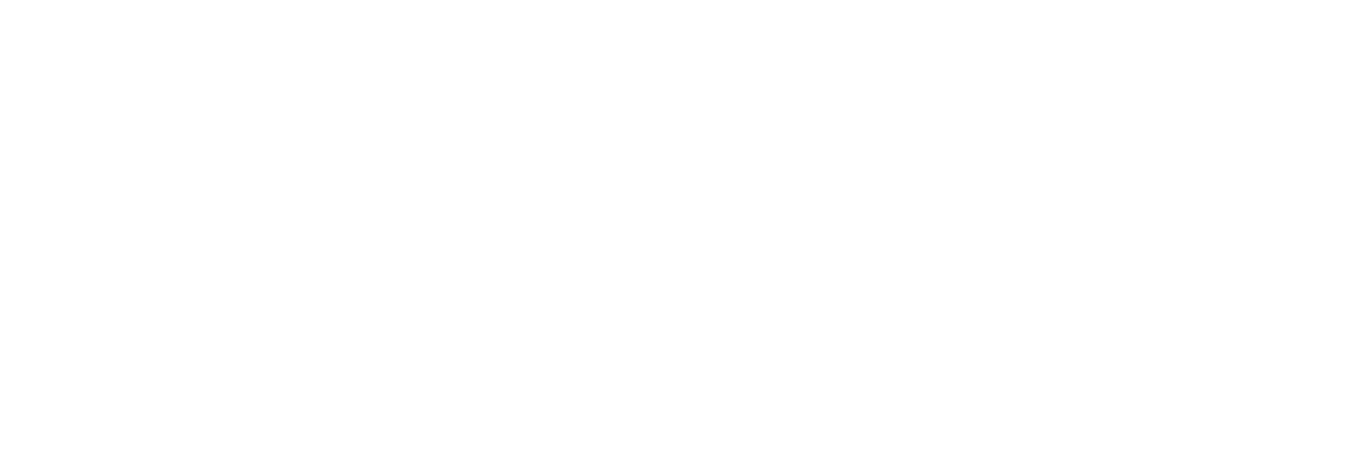

In [27]:
%matplotlib notebook
fig, axs = pl.subplots(1, 2, figsize = (12, 4))
ax = plot_fun(f, bounds =  plot_bounds, ax = axs[0])
current_dot = ax.scatter(*x_start, c = "green")

In [28]:
## initialization
x = x_start
f_x = f(x)
df_x = df(x)
B = np.eye(2)

In [29]:
wolfe_lin_srch = Wolfe_Linear_Search(
    f = f, df = df,
    
    c1=0.01, c2=0.4,
    
    max_noof_bracketing_steps=20, 
    max_noof_zooming_steps=40,
    
    ax = axs[1],
)

<IPython.core.display.Javascript object>


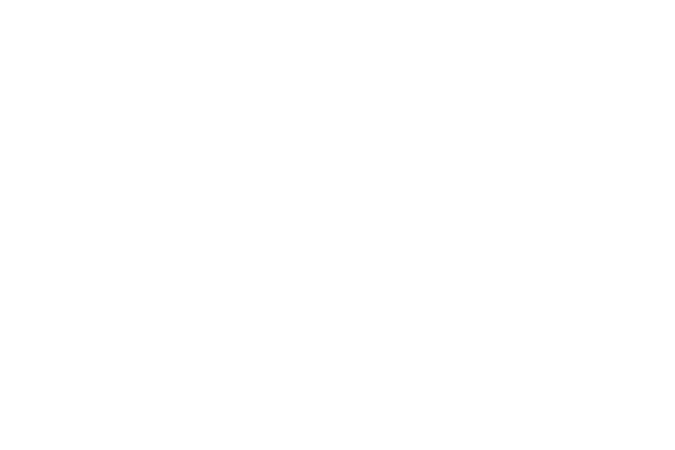

New bracketing step with a_prev=0; a=1
Sufficient descent fails.
phi_a >= phi_a_prev
You can start zooming with a_lo=0, a_hi=1
New zooming step with a_lo = 0; a_hi = 1
New zooming step with a_lo = 0; a_hi = 0.5
New zooming step with a_lo = 0; a_hi = 0.25
New zooming step with a_lo = 0.125; a_hi = 0
You are done and you can use alpha =0.0625
x =[-0.7875 -0.025 ]; f(x) = 0.6264062499999999


<IPython.core.display.Javascript object>


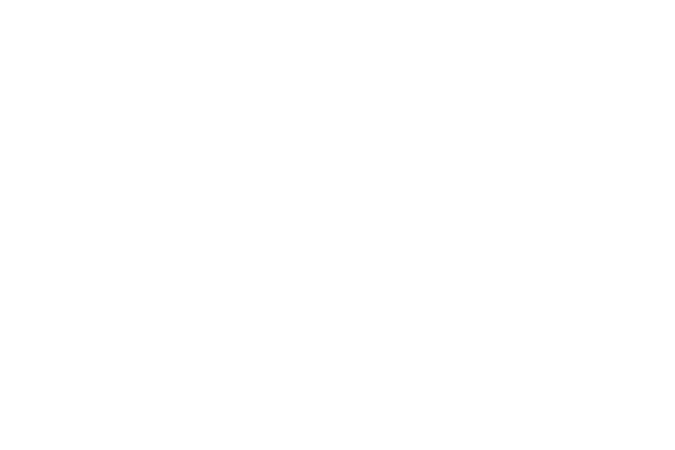

In [30]:
# BFGS Method
## find the direction `p`
p = - la.inv(B) @ df_x

## perform the line search ; 
## `lsr` = line search results  
lsr = wolfe_lin_srch.search(
    x = x, p = p,
    
)

## calculate BFGS update
B = BFGS_update_B(
    x0 = x,
    df_x0 = df_x,
    B0= B, 
    x1 = lsr.x_new,
    df_x1 = lsr.df_x_new 
)


## update `x, f_x, df_x`
x, f_x, df_x = lsr.x_new, lsr.f_x_new, lsr.df_x_new


## plotting and printing
current_dot.set_offsets([x])
print("x ={}; f(x) = {}".format(x, f(x)))